### This notebook contains a detailed walkthrough for training a semantic segmentation model on Mitochondria dataset using 3D UNet architecture. 

###### Reference: The code for 3D UNet was developed using the architecture from the paper '<i><u>3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation</u></i>' (https://arxiv.org/abs/1606.06650). Some references were taken from Abhishek Thakur's video on implementing 2D UNet from scratch.

### Load libraries

In [1]:
import numpy as np
from skimage import io

from sklearn.model_selection import train_test_split
from patchify import patchify


import torch
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from unet3d import Unet3d

from matplotlib import pyplot as plt


#### Clear GPU memory

In [2]:
torch.cuda.empty_cache() 

#### We define a class called 'Voxels' that takes the image and corresponding masks as the input and normalizes them. The images and masks are in the 'tif' format but major formats are also supported. We also create a method 'generate_voxels' that generates voxels of size 64x64x64 using the patchify library.

In [3]:
class Voxels:
    def __init__(self, image_path, mask_path):
        self.image = io.imread(image_path)
        self.mask = io.imread(mask_path)
        self.mask = np.where(self.mask==255, 1, 0) #Convert image mask into a binary mask
        
        #normalize the image
        self.image = (self.image - self.image.mean())/self.image.std()
        
    def generate_voxels(self, volume_size):
        image_volume = patchify(self.image, volume_size, step=volume_size[0])
        mask_volume = patchify(self.mask, volume_size, step=volume_size[0])
        
        image_voxels = image_volume.reshape(-1, 1, volume_size[0], volume_size[1], volume_size[2])
        mask_voxels = mask_volume.reshape(-1, volume_size[0],volume_size[1],volume_size[2])
        
        return image_voxels, mask_voxels
        
        
        
        

In [4]:
patcher = Voxels(image_path='./training.tif',  mask_path='./training_groundtruth.tif')

In [5]:
image_voxels, mask_voxels = patcher.generate_voxels((64,64,64))

#### To evaluate the perfomance of our model, we would split these voxels into training and validation sets. We have kept 80% of the dataset for training and remaining 20% for validation set.

In [7]:
voxels_train,voxels_val, mask_voxels_train,mask_voxels_val = train_test_split(image_voxels,
                                                                              mask_voxels, test_size=.2)

#### Next, we create a PyTorch Dataset and DataLoader class.

In [8]:
class MitochondriaDataset(Dataset):
    def __init__(self, image_voxels, mask_voxels):
        
        mask_voxels  = mask_voxels.astype('float32')
        image_voxels = image_voxels.astype('float32')
        
        
        self.image_voxels = torch.from_numpy(image_voxels)
        self.mask_voxels = torch.from_numpy(mask_voxels)
        self.mask_voxels = self.mask_voxels.type(torch.LongTensor)
        
    def __len__(self):
        return self.image_voxels.shape[0]
    
    def __getitem__(self,idx):
        return self.image_voxels[idx,:,:,:], self.mask_voxels[idx,:,:,:]
        

In [9]:
train_ds = MitochondriaDataset(voxels_train, mask_voxels_train)
val_ds = MitochondriaDataset(voxels_val, mask_voxels_val)

#### Wrap the dataset object around the PyTorch dataloader. We have kept the batch size as 2 to fit the voxels into GPU memory.

In [10]:
train_dl = DataLoader(train_ds,batch_size=2, shuffle=True)
val_dl = DataLoader(val_ds,batch_size=2, shuffle=False)

#### It is highly advisable to use GPU otherwise training would be really slow.

In [ ]:
device = torch.device("cuda:3" if torch.cuda.is_available()  else "cpu")


#### The images have unequal distribution of pixels belonging to mitochondria class(1) or not (0) i.e. the dataset poses a class imbalance problem. To solve this, we have assigned lower weights to the majority class and higher weights to the minority class. Later on, we would pass these weights into our loss function.

#### Reference: Code to compute class weights was referred from https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

In [12]:
def compute_class_weights(labels):
    
    class_weights = []
    
    n_classes = list(np.unique(mask_voxels))
    n_samples = labels.size
    
    for i in range(len(n_classes)):
        class_weights.append(n_samples/((len(n_classes))*np.sum(mask_voxels==i)))
        
    return class_weights

In [13]:
class_weights = compute_class_weights(mask_voxels)
class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)
class_weights

tensor([0.5316, 8.4175], device='cuda:3')

#### Next, we define number of classes and learning rate. We also intialize the 3D UNet model, Adam optimizer and loss fucntion along with computed class weights.

In [14]:
n_classes = 2
learning_rate = 1e-4


model = Unet3d(n_classes=n_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)


#### We define a function 'run_one_epoch' that iterates over the dataloader, computes cross entropy weighted loss, backpropogates the weight (only if dataloader is a training set, indicated by boolean flag) and finally computes the dice coefficient score.

#### Reference: The code for computing the dice coefficient was referred from open-sourced github repo under free license.

In [15]:
def run_one_epoch(dataloader, model, optimizer, train_flag=True):
    dice = []
    losses = []
    
    if train_flag:
        model.train()
    else:
        model.eval()
        
        
    for x,y in train_dl:
        x=x.to(device)
        y=y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        
        if train_flag:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        losses.append(loss.item())
        
        smooth = 1.
        y_pred = torch.sigmoid(y_pred)
        y_pred = torch.max(y_pred,1)[1]
        
        iflat = y_pred.contiguous().reshape(-1)
        tflat = y.contiguous().reshape(-1)
        intersection = (iflat * tflat).sum()
        
        A_sum = torch.sum(iflat * iflat)
        B_sum = torch.sum(tflat * tflat)
        
        dice.append(((2. * intersection + smooth) / (A_sum + B_sum + smooth)).item())
        
        
    return np.mean(losses), np.mean(dice)
        

#### Now that we have everything in place, let's  train the model for 10 epochs initially only and see how the loss function behaves. We would also save the loss values and dice coefficients at the end of every epoch.

In [16]:
train_losses = []
val_losses = []
train_dice = []
val_dice = []
for i in range(10):
    train_loss, train_dice_coeff = run_one_epoch(train_dl, model, optimizer)
    val_loss, val_dice_coeff = run_one_epoch(val_dl, model, optimizer, False)
    train_losses.append(train_loss)
    val_losses.append(val_loss)    
    train_dice.append(train_dice_coeff)
    val_dice.append(val_dice_coeff)
    print("train loss %.2f valid loss %.2f train_dice_coeff %.2f val_dice_coeff %.2f" %(train_loss, val_loss,train_dice_coeff, val_dice_coeff))

train loss 0.46 valid loss 0.25 train_dice_coeff 0.29 val_dice_coeff 0.35
train loss 0.35 valid loss 0.34 train_dice_coeff 0.34 val_dice_coeff 0.25
train loss 0.30 valid loss 0.19 train_dice_coeff 0.35 val_dice_coeff 0.38
train loss 0.25 valid loss 0.19 train_dice_coeff 0.36 val_dice_coeff 0.42
train loss 0.21 valid loss 0.16 train_dice_coeff 0.41 val_dice_coeff 0.40
train loss 0.19 valid loss 0.28 train_dice_coeff 0.40 val_dice_coeff 0.42
train loss 0.20 valid loss 0.13 train_dice_coeff 0.42 val_dice_coeff 0.46
train loss 0.17 valid loss 0.14 train_dice_coeff 0.40 val_dice_coeff 0.44
train loss 0.14 valid loss 0.12 train_dice_coeff 0.45 val_dice_coeff 0.42
train loss 0.12 valid loss 0.09 train_dice_coeff 0.48 val_dice_coeff 0.44


#### Since the dice coefficient score is low on validation set and loss is decreasing slowly, let's train the model for more number of epochs

In [17]:
for i in range(20):
    train_loss, train_dice_coeff = run_one_epoch(train_dl, model, optimizer)
    val_loss, val_dice_coeff = run_one_epoch(val_dl, model, optimizer, False)
    train_losses.append(train_loss)
    val_losses.append(val_loss)    
    train_dice.append(train_dice_coeff)
    val_dice.append(val_dice_coeff)
    print("train loss %.2f valid loss %.2f train_dice_coeff %.2f val_dice_coeff %.2f" %(train_loss, val_loss,train_dice_coeff, val_dice_coeff))

train loss 0.12 valid loss 0.12 train_dice_coeff 0.45 val_dice_coeff 0.41
train loss 0.12 valid loss 0.08 train_dice_coeff 0.45 val_dice_coeff 0.50
train loss 0.12 valid loss 0.09 train_dice_coeff 0.47 val_dice_coeff 0.51
train loss 0.10 valid loss 0.07 train_dice_coeff 0.48 val_dice_coeff 0.49
train loss 0.09 valid loss 0.06 train_dice_coeff 0.48 val_dice_coeff 0.56
train loss 0.07 valid loss 0.10 train_dice_coeff 0.50 val_dice_coeff 0.40
train loss 0.11 valid loss 0.07 train_dice_coeff 0.44 val_dice_coeff 0.52
train loss 0.09 valid loss 0.06 train_dice_coeff 0.49 val_dice_coeff 0.50
train loss 0.06 valid loss 0.05 train_dice_coeff 0.50 val_dice_coeff 0.55
train loss 0.06 valid loss 0.05 train_dice_coeff 0.54 val_dice_coeff 0.51
train loss 0.09 valid loss 0.06 train_dice_coeff 0.49 val_dice_coeff 0.54
train loss 0.09 valid loss 0.05 train_dice_coeff 0.46 val_dice_coeff 0.52
train loss 0.05 valid loss 0.04 train_dice_coeff 0.52 val_dice_coeff 0.52
train loss 0.08 valid loss 0.05 train_

In [18]:
for i in range(10):
    train_loss, train_dice_coeff = run_one_epoch(train_dl, model, optimizer)
    val_loss, val_dice_coeff = run_one_epoch(val_dl, model, optimizer, False)
    train_losses.append(train_loss)
    val_losses.append(val_loss)    
    train_dice.append(train_dice_coeff)
    val_dice.append(val_dice_coeff)
    print("train loss %.2f valid loss %.2f train_dice_coeff %.2f val_dice_coeff %.2f" %(train_loss, val_loss,train_dice_coeff, val_dice_coeff))

train loss 0.04 valid loss 0.03 train_dice_coeff 0.55 val_dice_coeff 0.56
train loss 0.04 valid loss 0.03 train_dice_coeff 0.57 val_dice_coeff 0.54
train loss 0.04 valid loss 0.03 train_dice_coeff 0.56 val_dice_coeff 0.57
train loss 0.03 valid loss 0.03 train_dice_coeff 0.59 val_dice_coeff 0.58
train loss 0.03 valid loss 0.03 train_dice_coeff 0.61 val_dice_coeff 0.63
train loss 0.03 valid loss 0.03 train_dice_coeff 0.61 val_dice_coeff 0.59
train loss 0.03 valid loss 0.03 train_dice_coeff 0.64 val_dice_coeff 0.63
train loss 0.03 valid loss 0.03 train_dice_coeff 0.66 val_dice_coeff 0.65
train loss 0.04 valid loss 0.07 train_dice_coeff 0.58 val_dice_coeff 0.45
train loss 0.14 valid loss 0.07 train_dice_coeff 0.41 val_dice_coeff 0.50


In [19]:
for i in range(10):
    train_loss, train_dice_coeff = run_one_epoch(train_dl, model, optimizer)
    val_loss, val_dice_coeff = run_one_epoch(val_dl, model, optimizer, False)
    train_losses.append(train_loss)
    val_losses.append(val_loss)    
    train_dice.append(train_dice_coeff)
    val_dice.append(val_dice_coeff)
    print("train loss %.2f valid loss %.2f train_dice_coeff %.2f val_dice_coeff %.2f" %(train_loss, val_loss,train_dice_coeff, val_dice_coeff))

train loss 0.05 valid loss 0.03 train_dice_coeff 0.54 val_dice_coeff 0.57
train loss 0.03 valid loss 0.03 train_dice_coeff 0.59 val_dice_coeff 0.60
train loss 0.03 valid loss 0.02 train_dice_coeff 0.60 val_dice_coeff 0.63
train loss 0.03 valid loss 0.02 train_dice_coeff 0.60 val_dice_coeff 0.61
train loss 0.03 valid loss 0.02 train_dice_coeff 0.64 val_dice_coeff 0.62
train loss 0.03 valid loss 0.02 train_dice_coeff 0.65 val_dice_coeff 0.63
train loss 0.03 valid loss 0.03 train_dice_coeff 0.65 val_dice_coeff 0.68
train loss 0.03 valid loss 0.02 train_dice_coeff 0.65 val_dice_coeff 0.60
train loss 0.02 valid loss 0.02 train_dice_coeff 0.66 val_dice_coeff 0.60
train loss 0.02 valid loss 0.02 train_dice_coeff 0.70 val_dice_coeff 0.66


#### We achieved dice coefficient score of 0.66 on the validation set after training the model for 50 epochs.

#### Let's plot training and validation loss vs number of epochs to inspect the training behaviour.

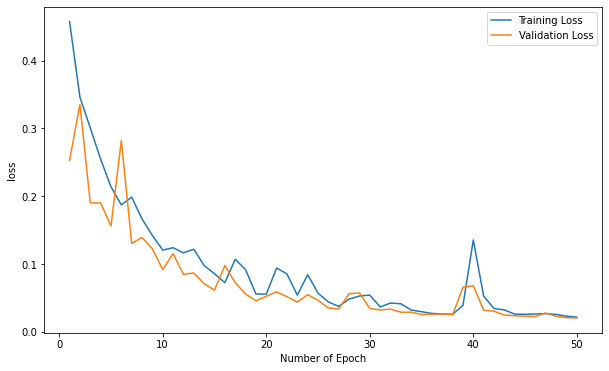

In [34]:
fig, ax = plt.subplots(1, figsize=(10,6))

ax.plot(range(1,51),train_losses,label = "Training Loss")
ax.plot(range(1,51), val_losses,label = "Validation Loss")
ax.set_xlabel('Number of Epoch') 
ax.set_ylabel('loss')    
plt.legend()   
plt.show()    

#### Plot Training and Validation Dice Coefficient score vs Number of Epochs.

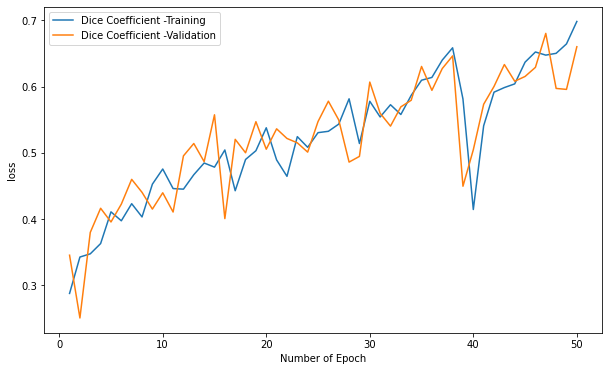

In [33]:
fig, ax = plt.subplots(1, figsize=(10,6))

ax.plot(range(1,51),train_dice,label = "Dice Coefficient -Training")
ax.plot(range(1,51), val_dice,label = "Dice Coefficient -Validation")
ax.set_xlabel('Number of Epoch') 
ax.set_ylabel('loss')    
plt.legend()   
plt.show()    

#### Save the model

In [23]:
torch.save(model.state_dict(), './model_3DUnet.pth')